In [1]:
import heapq
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict


In [2]:
@dataclass
class Order:
    order_id: int
    side: str        # "buy" or "sell"
    price: float
    qty: int
    timestamp: int


In [3]:
class OrderBook:
    def __init__(self):
        self.bids = []     # max heap (negative price)
        self.asks = []     # min heap
        self.trades = []   # trade tape
        self.time = 0      # discrete event clock

    def submit(self, side, price, qty):
        self.time += 1
        order = Order(
            order_id=self.time,
            side=side,
            price=price,
            qty=qty,
            timestamp=self.time
        )

        if side == "buy":
            heapq.heappush(self.bids, (-price, order.timestamp, order))
        else:
            heapq.heappush(self.asks, (price, order.timestamp, order))

        self.match()

    def match(self):
        while self.bids and self.asks:
            bid_price, _, bid = self.bids[0]
            ask_price, _, ask = self.asks[0]

            bid_price = -bid_price

            if bid_price < ask_price:
                break

            trade_qty = min(bid.qty, ask.qty)

            self.trades.append({
                "price": ask_price,
                "qty": trade_qty,
                "aggressor": "buy",
                "timestamp": self.time
            })

            bid.qty -= trade_qty
            ask.qty -= trade_qty

            if bid.qty == 0:
                heapq.heappop(self.bids)
            if ask.qty == 0:
                heapq.heappop(self.asks)


In [4]:
def best_bid_ask(ob):
    best_bid = -ob.bids[0][0] if ob.bids else None
    best_ask = ob.asks[0][0] if ob.asks else None
    return best_bid, best_ask


In [5]:
def depth_snapshot(ob, levels=10):
    bid_depth = defaultdict(int)
    ask_depth = defaultdict(int)

    for p, _, o in ob.bids:
        bid_depth[-p] += o.qty

    for p, _, o in ob.asks:
        ask_depth[p] += o.qty

    bids = sorted(bid_depth.items(), reverse=True)[:levels]
    asks = sorted(ask_depth.items())[:levels]

    return bids, asks


In [6]:
def plot_depth(bids, asks, title):
    if bids:
        bid_prices, bid_qtys = zip(*bids)
    else:
        bid_prices, bid_qtys = [], []

    if asks:
        ask_prices, ask_qtys = zip(*asks)
    else:
        ask_prices, ask_qtys = [], []

    plt.figure(figsize=(8, 5))
    plt.bar(bid_prices, bid_qtys)
    plt.bar(ask_prices, ask_qtys)
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.title(title)
    plt.show()


In [7]:
def poisson_traders(ob, n_traders=1000, base_price=100, scale=1.5):
    for _ in range(n_traders):
        side = random.choice(["buy", "sell"])
        price_offset = np.random.exponential(scale=scale)

        if side == "buy":
            price = base_price - price_offset
        else:
            price = base_price + price_offset

        qty = random.randint(1, 10)
        ob.submit(side, round(price, 2), qty)


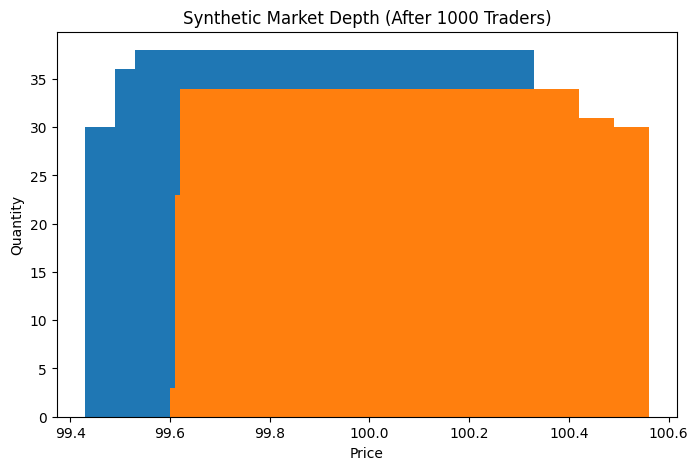

In [8]:
ob = OrderBook()
poisson_traders(ob, n_traders=1000, base_price=100)

bids, asks = depth_snapshot(ob, levels=15)
plot_depth(bids, asks, "Synthetic Market Depth (After 1000 Traders)")


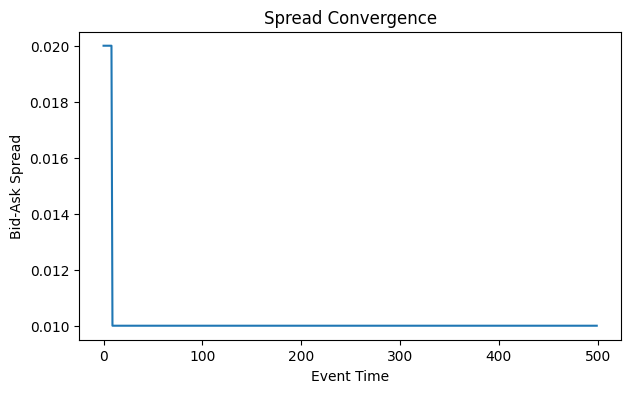

In [9]:
spreads = []

for _ in range(500):
    poisson_traders(ob, n_traders=1, base_price=100)
    bid, ask = best_bid_ask(ob)
    if bid and ask:
        spreads.append(ask - bid)

plt.figure(figsize=(7,4))
plt.plot(spreads)
plt.xlabel("Event Time")
plt.ylabel("Bid-Ask Spread")
plt.title("Spread Convergence")
plt.show()


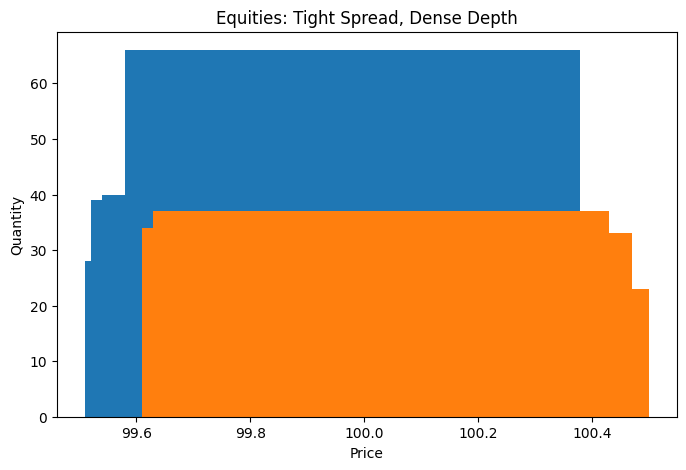

In [10]:
ob_eq = OrderBook()
poisson_traders(ob_eq, n_traders=1000, base_price=100, scale=0.8)

bids_eq, asks_eq = depth_snapshot(ob_eq)
plot_depth(bids_eq, asks_eq, "Equities: Tight Spread, Dense Depth")


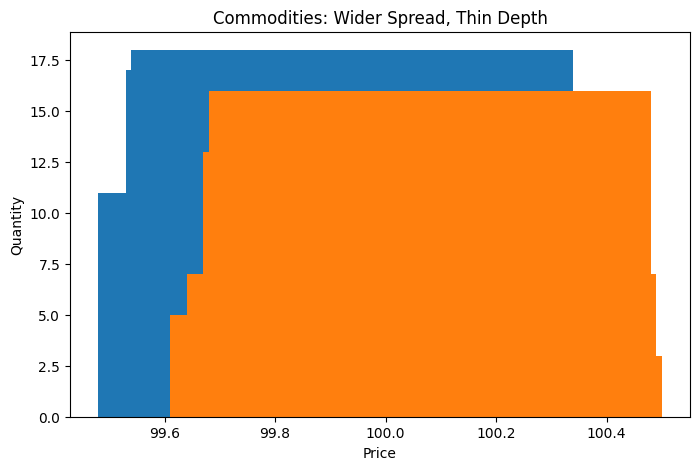

In [11]:
ob_com = OrderBook()
poisson_traders(ob_com, n_traders=1000, base_price=100, scale=3.0)

bids_com, asks_com = depth_snapshot(ob_com)
plot_depth(bids_com, asks_com, "Commodities: Wider Spread, Thin Depth")
